In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python-headless matplotlib scikit-learn pandas numpy joblib


In [ ]:
import os, glob, pandas as pd

data_dir = '/content/drive/MyDrive/eye-tracking-project/results'
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

if len(csv_files) == 0:
    print("Nenhum CSV encontrado! Verifique a pasta.")
else:
    print(f"CSV encontrados: {len(csv_files)}")

dfs = [pd.read_csv(f) for f in csv_files]
all_df = pd.concat(dfs, ignore_index=True)

all_df.head()


CSV encontrados: 3


,participant,stimulus,timestamp_ms,x,y,screen_w,screen_h
0,P01,stim_A_03.png,36,612,322,1536,738
1,P01,stim_A_03.png,75,648,259,1536,738
2,P01,stim_A_03.png,112,679,203,1536,738
3,P01,stim_A_03.png,149,750,154,1536,738
4,P01,stim_A_03.png,216,805,115,1536,738


In [ ]:
import numpy as np

def detect_fixations(df, velocity_threshold=30):
    fixations = []
    df = df.sort_values(by="timestamp_ms").reset_index(drop=True)

    for i in range(1, len(df)):
        dx = df.loc[i, "x"] - df.loc[i-1, "x"]
        dy = df.loc[i, "y"] - df.loc[i-1, "y"]
        dt = (df.loc[i, "timestamp_ms"] - df.loc[i-1, "timestamp_ms"]) / 1000

        if dt == 0:
            continue

        velocity = np.sqrt(dx*dx + dy*dy) / dt

        if velocity < velocity_threshold:
            fixations.append(df.loc[i])

    return pd.DataFrame(fixations)


In [ ]:
AOIs = {
    "aoi_top_left":     {"x1":0,    "y1":0,    "x2":640,  "y2":360},
    "aoi_bottom_right": {"x1":640,  "y1":360,  "x2":1280, "y2":720}
}


In [ ]:
def map_aoi(x, y):
    for name, coords in AOIs.items():
        if coords["x1"] <= x <= coords["x2"] and coords["y1"] <= y <= coords["y2"]:
            return name
    return "none"


In [ ]:
fix_df = detect_fixations(all_df)
fix_df["aoi"] = fix_df.apply(lambda row: map_aoi(row["x"], row["y"]), axis=1)
fix_df.head()


,participant,stimulus,timestamp_ms,x,y,screen_w,screen_h,aoi
113,P02,stim_A_03.png,232,531,132,1536,738,aoi_top_left
213,P03,stim_B_03.png,438,546,135,1536,738,aoi_top_left
378,P02,stim_A_02.png,769,501,124,1536,738,aoi_top_left
427,P02,stim_B_03.png,869,548,136,1536,738,aoi_top_left
449,P01,stim_A_01.png,913,545,135,1536,738,aoi_top_left


In [ ]:
features = fix_df.groupby(["participant", "stimulus", "aoi"]).agg({
    "timestamp_ms": ["count", "mean"]
})

features.columns = ["fixation_count", "avg_timestamp"]
features = features.reset_index()
features.head()


,participant,stimulus,aoi,fixation_count,avg_timestamp
0,P01,stim_A_01.png,aoi_top_left,1,913.0
1,P02,stim_A_02.png,aoi_top_left,1,769.0
2,P02,stim_A_03.png,aoi_top_left,2,1797.0
3,P02,stim_B_01.png,aoi_top_left,1,1847.0
4,P02,stim_B_03.png,aoi_top_left,1,869.0


In [ ]:
threshold = features["fixation_count"].quantile(0.70)
features["label"] = features["fixation_count"].apply(lambda v: 1 if v >= threshold else 0)

features.head()


,participant,stimulus,aoi,fixation_count,avg_timestamp,label
0,P01,stim_A_01.png,aoi_top_left,1,913.0,1
1,P02,stim_A_02.png,aoi_top_left,1,769.0,1
2,P02,stim_A_03.png,aoi_top_left,2,1797.0,1
3,P02,stim_B_01.png,aoi_top_left,1,1847.0,1
4,P02,stim_B_03.png,aoi_top_left,1,869.0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = features[["fixation_count", "avg_timestamp"]].values
y = features["label"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Xtr, Xte, ytr, yte = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(Xtr, ytr)

print("Acurácia Treino:", clf.score(Xtr, ytr))
print("Acurácia Teste:", clf.score(Xte, yte))


Acurácia Treino: 1.0
Acurácia Teste: 1.0


In [ ]:
import joblib

# salvar o modelo treinado
joblib.dump(clf, "rf_attention.pkl")

# salvar o scaler usado nas features
joblib.dump(scaler, "scaler.pkl")

print("Arquivos salvos com sucesso!")



Arquivos salvos com sucesso!


In [ ]:
import joblib

model_dir = "/content/drive/MyDrive/eye-tracking-project/model"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(clf, model_dir + "/rf_attention.pkl")
joblib.dump(scaler, model_dir + "/scaler.pkl")

print("Modelo salvo com sucesso!")


Modelo salvo com sucesso!


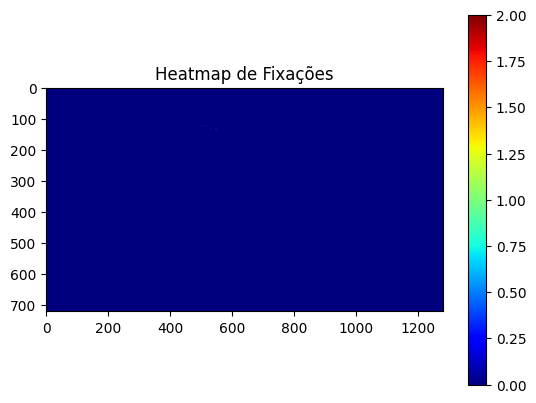

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_w, img_h = 1280, 720
heatmap = np.zeros((img_h, img_w))

for _, row in fix_df.iterrows():
    x = int(row["x"])
    y = int(row["y"])
    if 0 <= x < img_w and 0 <= y < img_h:
        heatmap[y, x] += 1

plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap de Fixações")
plt.colorbar()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

overlay_dir = '/content/drive/MyDrive/eye-tracking-project/heatmaps_overlay'
os.makedirs(overlay_dir, exist_ok=True)

for stim in fix_df['stimulus'].unique():

    # converte .png para .jpg automaticamente
    img_file = stim.replace('.png', '.jpg')
    img_path = f"/content/drive/MyDrive/eye-tracking-project/stimuli/{img_file}"

    # carrega a imagem
    img = cv2.imread(img_path)

    if img is None:
        print(f"ERRO: não encontrou a imagem {img_file}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape
    heatmap = np.zeros((h, w))

    df_stim = fix_df[fix_df['stimulus'] == stim]

    for _, row in df_stim.iterrows():
        x, y = int(row["x"]), int(row["y"])
        if 0 <= x < w and 0 <= y < h:
            heatmap[y, x] += 1

    heatmap = cv2.GaussianBlur(heatmap, (51, 51), 0)
    heatmap_norm = heatmap / (heatmap.max() + 1e-6)

    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.imshow(heatmap_norm, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Heatmap Overlay - {stim}")

    out_path = f"{overlay_dir}/overlay_{stim.replace('.png','.jpg')}"
    plt.savefig(out_path, bbox_inches='tight')
    plt.close()

print("Heatmaps overlay GERADOS com sucesso!")


Heatmaps overlay GERADOS com sucesso!
